In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glhmm.glhmm as glhmm
import seaborn as sns
import network_tools as nt
import importlib
import networkx as nx
import dynamics as dyn
from scipy.linalg import eig
import csv
from sklearn.cluster import KMeans,MiniBatchKMeans
import statespacesplitting as sss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib
import hmm_helper as hmmh
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
importlib.reload(nt)
importlib.reload(dyn)
importlib.reload(sss)
importlib.reload(hmmh)

<module 'hmm_helper' from '/home/nartallokalu/Desktop/hmm/hmm_helper.py'>

In [17]:
N = 100
W = nt.generate_hierarchical_network(N,mu = 0.2,p0 = 1,recip = 20)

In [31]:
Theta = 2
gamma = 0.2
sigma = 0.05
dt = 0.05
steps = 1000
print(np.real(np.linalg.eig(Theta*(np.diag(np.ones(N))-gamma*W)).eigenvalues)>0)
Phi = dyn.EPR_network_ornstein_uhlenbeck(W,sigma,Theta,gamma)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [33]:
W_df = pd.DataFrame(W)
W_df.to_csv('W.csv',index=False)

In [34]:
[X,t] = dyn.network_ornstein_uhlenbeck(nt.parameterise_network(W,1),sigma,Theta,gamma,dt,steps)
tau = 20
X_sampled = X[:,0::tau]
t_sampled= t[0::tau]

In [35]:
sc = StandardScaler()
X_std = sc.fit_transform(np.transpose(X))
pca = PCA(n_components=3)
X_pca = pca.fit(X_std)
X_pca = np.transpose(pca.transform(X_std))

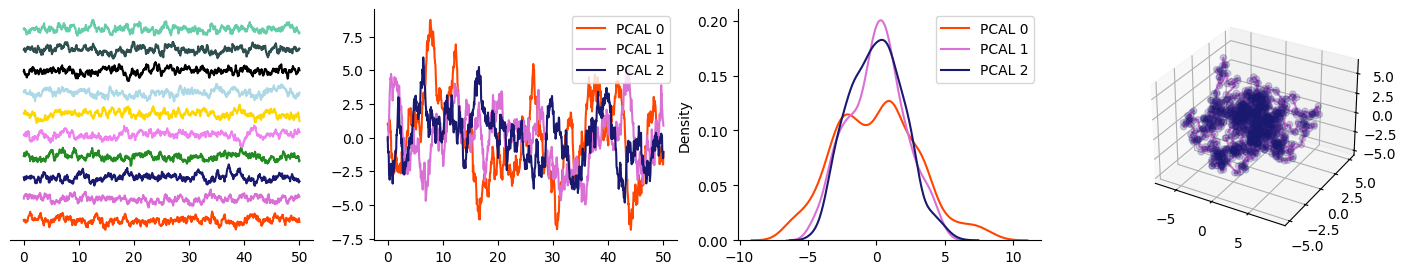

<Figure size 640x480 with 0 Axes>

In [36]:
fig = plt.figure()
axs=[0,0,0,0]
axs[0] = fig.add_subplot(1,4,1)
axs[1] = fig.add_subplot(1,4,2)
axs[3] = fig.add_subplot(1,4,4,projection='3d')
axs[2] = fig.add_subplot(1,4,3)
fig.set_size_inches(18,3)
colours =['orangered','orchid','midnightblue','forestgreen','violet','gold','lightblue','black','darkslategrey','mediumaquamarine']
for i in range(0,10):
    sns.lineplot(x=t,y=X[i,:]+2*i,ax=axs[0],color=colours[i])
    sns.despine()

ax = plt.gca()
ax.spines["bottom"].set_visible(False)
for i in range(0,3):
    sns.lineplot(x=t,y=X_pca[i,:],ax=axs[1],color=colours[i],label= 'PCAL ' + str(i))
    sns.kdeplot(X_pca[i,:],ax=axs[2],color=colours[i],label= 'PCAL ' + str(i))
    sns.despine()
axs[3].plot(X_pca[0,:], X_pca[1,:], X_pca[2,:], color = 'orchid')
axs[3].scatter(X_pca[0,:], X_pca[1,:], X_pca[2,:], color = 'midnightblue',alpha=0.2)
axs[0].set_yticklabels([])
axs[0].set_yticks([])
ax = plt.gca()
axs[0].spines["left"].set_visible(False)
axs[1].legend()
sns.move_legend(axs[1], "upper right")
axs[2].legend()
plt.show()
sns.despine()
plt.tight_layout()
plt.show()

# Coarse-graining

/tmp/ipykernel_819008/1540578541.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


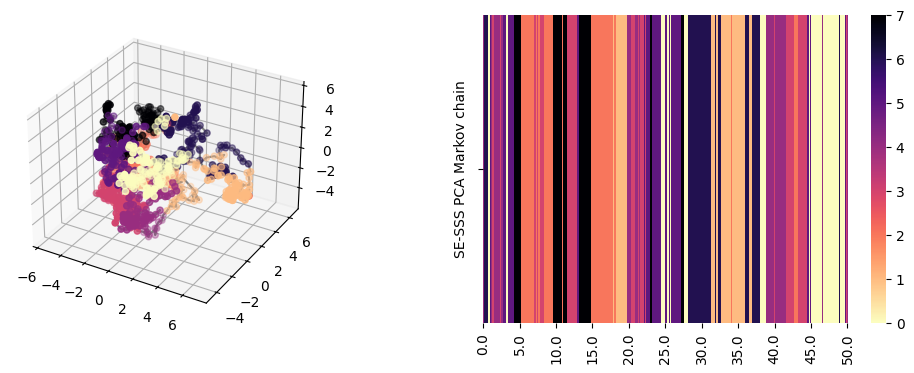

In [9]:
box_tc, box_idx_tc = sss.state_space_split(X_pca,3,sss.boundary_list_stat_even(X_pca,[2,2,2]))
colours =['orangered','orchid','midnightblue','forestgreen','violet','gold','lightblue','black']
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(box_idx_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X_pca[0,np.where(bidx==i)[0]], X_pca[1,np.where(bidx==i)[0]], X_pca[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X_pca[0,], X_pca[1,], X_pca[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('SE-SSS PCA Markov chain')
plt.show()
SE_SSS_TP = dyn.markov_chain_to_TP(box_idx_tc,8)

/tmp/ipykernel_819008/525315037.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


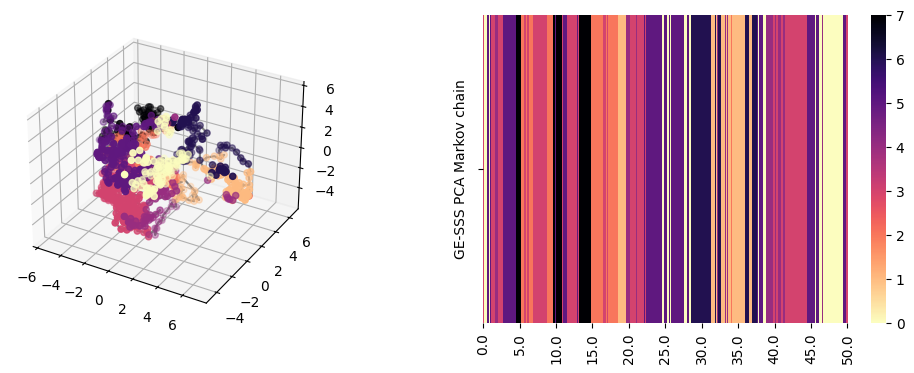

In [10]:
box_tc, box_idx_tc = sss.state_space_split(X_pca,3,sss.boundary_list_geom_even(X_pca,[2,2,2]))
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(box_idx_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X_pca[0,np.where(bidx==i)[0]], X_pca[1,np.where(bidx==i)[0]], X_pca[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X_pca[0,], X_pca[1,], X_pca[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('GE-SSS PCA Markov chain')
plt.show()
GE_SSS_TP = dyn.markov_chain_to_TP(box_idx_tc,8)

Init repetition 1 free energy = 38080.17296195368
Init repetition 2 free energy = 38203.17450866252
Init repetition 3 free energy = 38923.970863742055
Init repetition 4 free energy = 39670.41571239447
Init repetition 5 free energy = 39805.93674571
Best repetition: 1
Cycle 1 free energy = 38279.733049304465
Cycle 2 free energy = 38080.179824026694
Cycle 3, free energy = 38080.173030847756, relative change = 3.4040781267867396e-05
Cycle 4, free energy = 38080.17296498584, relative change = 3.300355259758623e-07
Cycle 5, free energy = 38080.17294834525, relative change = 8.33863478766401e-08
Cycle 6, free energy = 38080.172941167395, relative change = 3.596839039965451e-08
Cycle 7, free energy = 38080.17293787379, relative change = 1.650433901644987e-08
Cycle 8, free energy = 38080.172936321986, relative change = 7.776111492651128e-09
Cycle 9, free energy = 38080.172935580165, relative change = 3.717277188862135e-09
Cycle 10, free energy = 38080.17293522257, relative change = 1.7919350591

/tmp/ipykernel_819008/1785995059.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


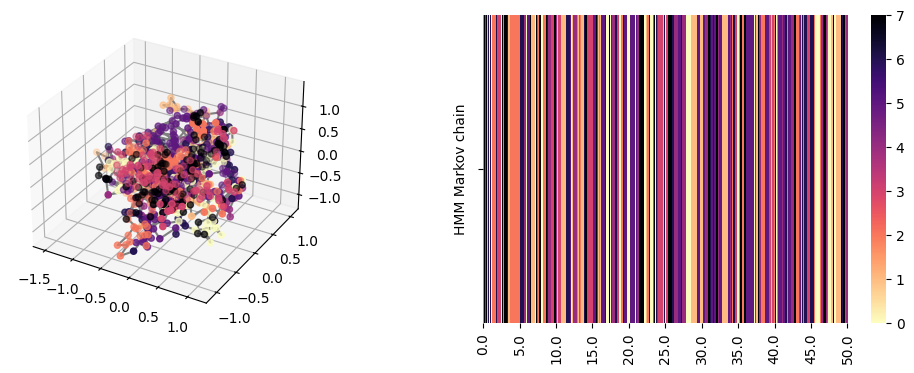

In [11]:
hmm = glhmm.glhmm(model_beta='no', K=8, covtype='full')
hmm.train(X=None, Y=np.transpose(X))
hmm_tc = hmmh.vector_time_course_to_tc(hmm.decode(X=None, Y=np.transpose(X),viterbi=True))
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(hmm_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":hmm_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('HMM Markov chain')
plt.show()

Init repetition 1 free energy = 5720.160859943218
Init repetition 2 free energy = 5757.029536502385
Init repetition 3 free energy = 5696.240368856984
Init repetition 4 free energy = 5838.523359704944
Init repetition 5 free energy = 5793.349629173758
Best repetition: 3
Cycle 1 free energy = 5726.120015195926
Cycle 2 free energy = 5652.759197308401
Cycle 3, free energy = 5651.514675143001, relative change = 0.016681408656765092
Cycle 4, free energy = 5651.237271984821, relative change = 0.003704500480147205
Cycle 5, free energy = 5651.034894582906, relative change = 0.0026953063438154455
Cycle 6, free energy = 5650.340100675463, relative change = 0.009168576024928626
Cycle 7, free energy = 5647.830094074126, relative change = 0.03206040529064336
Cycle 8, free energy = 5646.420305877959, relative change = 0.017688749535355205
Cycle 9, free energy = 5646.067512301726, relative change = 0.004407027431726801
Cycle 10, free energy = 5645.851161215584, relative change = 0.0026953304477836406
C

/tmp/ipykernel_819008/4023026211.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


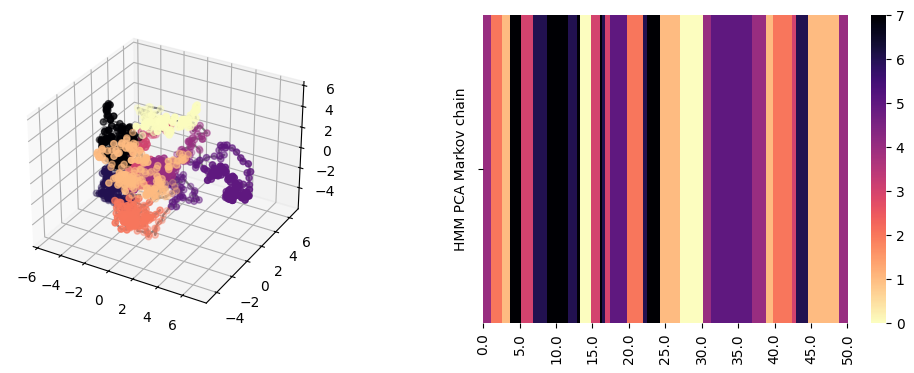

In [12]:
hmm = glhmm.glhmm(model_beta='no', K=8, covtype='full')
hmm.train(X=None, Y=np.transpose(X_pca))
hmm_tc = hmmh.vector_time_course_to_tc(hmm.decode(X=None, Y=np.transpose(X_pca),viterbi=True))
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(hmm_tc)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X_pca[0,np.where(bidx==i)[0]], X_pca[1,np.where(bidx==i)[0]], X_pca[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X_pca[0,], X_pca[1,], X_pca[2,], color = 'grey')
df = pd.DataFrame({"SSS":hmm_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('HMM PCA Markov chain')
plt.show()

/tmp/ipykernel_819008/783543047.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


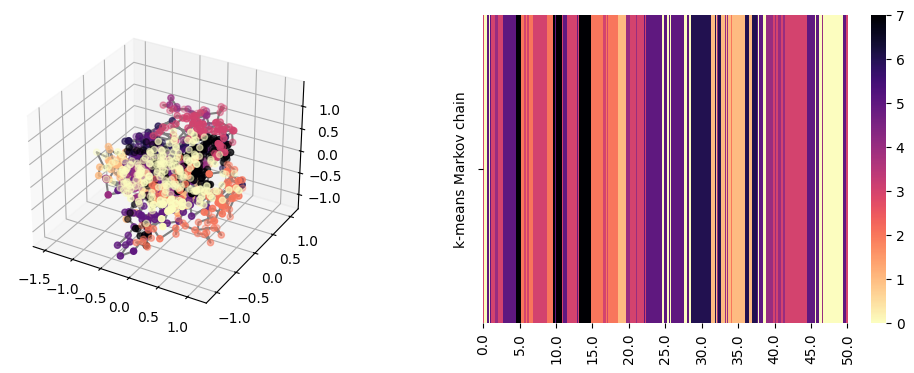

In [13]:
kmeans = KMeans(n_clusters = 8).fit(np.transpose(X))
kmeans.labels_
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(kmeans.labels_)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X[0,np.where(bidx==i)[0]], X[1,np.where(bidx==i)[0]], X[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X[0,], X[1,], X[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('k-means Markov chain')
plt.show()

/tmp/ipykernel_819008/4272095505.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma_r')


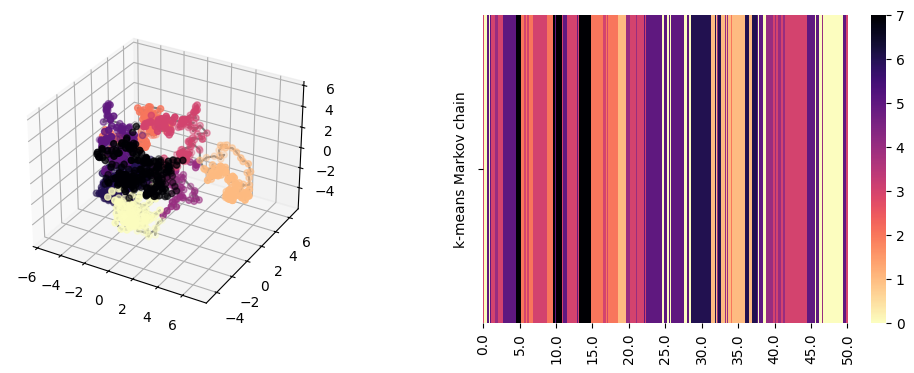

In [15]:
kmeans = KMeans(n_clusters = 8).fit(np.transpose(X_pca))
kmeans.labels_
fig = plt.figure()
fig.set_size_inches(20,4)
axs=[0,0]
axs[1] = fig.add_subplot(1,3,2)
axs[0] = fig.add_subplot(1,3,1,projection='3d')
bidx = np.array(kmeans.labels_)
for i in range(0,8):
    cmap = matplotlib.cm.get_cmap('magma_r')
    rgba = cmap(i/7)
    axs[0].scatter(X_pca[0,np.where(bidx==i)[0]], X_pca[1,np.where(bidx==i)[0]], X_pca[2,np.where(bidx==i)[0]], color = rgba)
axs[0].plot(X_pca[0,], X_pca[1,], X_pca[2,], color = 'grey')
df = pd.DataFrame({"SSS":box_idx_tc},index =t)
sns.heatmap(np.transpose(df),cmap='magma_r',ax=axs[1])
axs[1].set_xticks(np.linspace(0,1000,11))
axs[1].set_xticklabels(np.linspace(0,50,11))
axs[1].set_yticklabels('')
axs[1].set_ylabel('k-means Markov chain')
plt.show()

# Sweep

In [ ]:
sc = StandardScaler()


EPR_true = []
trials = 50
eps_N = 100
EPR_kmeans_JSD =np.zeros((trials,eps_N))
EPR_HMM_JSD =np.zeros((trials,eps_N))
EPR_kmeans_PCA_JSD =np.zeros((trials,eps_N))
EPR_HMM__PCA_JSD =np.zeros((trials,eps_N))
EPR_SESSS_JSD =np.zeros((trials,eps_N))
EPR_GESSS_JSD =np.zeros((trials,eps_N))

K=8
eps_range = np.linspace(0,1,eps_N)

for eps_i in range(0,eps_N):
    eps = eps_range[eps_i]
    W_hat = nt.parameterise_network(W,eps)
    Phi = dyn.EPR_network_ornstein_uhlenbeck(W_hat,sigma,Theta,gamma)
    EPR_true.append(Phi)
    for trial in range(0,trials):
        [X,t] = dyn.network_ornstein_uhlenbeck(nt.parameterise_network(W,eps),sigma,Theta,gamma,dt,steps=5000)

        kmeans = KMeans(n_clusters = K).fit(np.transpose(X))
        km_JTP = dyn.markov_chain_to_JTP(kmeans.labels_,N=K)
        EPR_kmeans_JSD[trial,eps_i]= dyn.EPR_markov_chain_joint_JSD(km_JTP)

        hmm = glhmm.glhmm(model_beta='no', K=8, covtype='full')
        hmm.train(X=None, Y=np.transpose(X))
        hmm_tc = hmmh.vector_time_course_to_tc(hmm.decode(X=None, Y=np.transpose(X),viterbi=True))
        hmm_JTP = dyn.markov_chain_to_JTP(hmm_tc,N=K)
        EPR_HMM_JSD[trial,eps_i]= dyn.EPR_markov_chain_joint_JSD(hmm_JTP)


        X_std = sc.fit_transform(np.transpose(X))
        pca = PCA(n_components=3)
        X_pca = pca.fit(X_std)
        X_pca = np.transpose(pca.transform(X_std))

        kmeans = KMeans(n_clusters = K).fit(np.transpose(X_pca))
        km_JTP = dyn.markov_chain_to_JTP(kmeans.labels_,N=K)
        EPR_kmeans_PCA_JSD[trial,eps_i]= dyn.EPR_markov_chain_joint_JSD(km_JTP)

        hmm = glhmm.glhmm(model_beta='no', K=8, covtype='full')
        hmm.train(X=None, Y=np.transpose(X_pca))
        hmm_tc = hmmh.vector_time_course_to_tc(hmm.decode(X=None, Y=np.transpose(X_pca),viterbi=True))
        hmm_JTP = dyn.markov_chain_to_JTP(hmm_tc,N=K)
        EPR_HMM_PCA_JSD[trial,eps_i]= dyn.EPR_markov_chain_joint_JSD(hmm_JTP)

        box_tc, box_idx_tc = sss.state_space_split(X,3,sss.boundary_list_geom_even(X_pca,[2,2,2]))
        gesss_JTP = dyn.markov_chain_to_JTP(box_idx_tc,N=K)
        EPR_GESSS_JSD[trial,eps_i]= dyn.EPR_markov_chain_joint_JSD(gesss_JTP)

        box_tc, box_idx_tc = sss.state_space_split(X,3,sss.boundary_list_stat_even(X_pca,[2,2,2]))
        sesss_JTP = dyn.markov_chain_to_JTP(box_idx_tc,N=K)
        EPR_SESSS_JSD[trial,eps_i]= dyn.EPR_markov_chain_joint_JSD(sesss_JTP)


EPR_kmeans_JSD = pd.DataFrame(EPR_kmeans_JSD)
EPR_kmeans_JSD.to_csv('EPRkmeansJSD.csv',index=False)
EPR_HMM_JSD = pd.DataFrame(EPR_HMM_JSD)
EPR_HMM_JSD.to_csv('EPR_HMM_JSD.csv',index=False)

EPR_kmeans_PCA_JSD = pd.DataFrame(EPR_kmeans_PCA_JSD)
EPR_kmeans_PCA_JSD.to_csv('EPRkmeansPCAJSD.csv',index=False)
EPR_HMM_PCA_JSD = pd.DataFrame(EPR_HMM_PCA_JSD)
EPR_HMM_PCA_JSD.to_csv('EPR_HMM_PCA_JSD.csv',index=False)

EPR_GESSS_JSD = pd.DataFrame(EPR_GESSS_JSD)
EPR_GESSS_JSD.to_csv('EPR_GESSS_JSD.csv',index=False)
EPR_SESSS_JSD = pd.DataFrame(EPR_SESSS_JSD)
EPR_SESSS_JSD.to_csv('EPR_SESSS_JSD.csv',index=False)

EPR_true = pd.DataFrame(EPR_true)
EPR_true.to_csv('EPR_true.csv',index=False)